Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteWK3DFV/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteWK3DFV/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                     

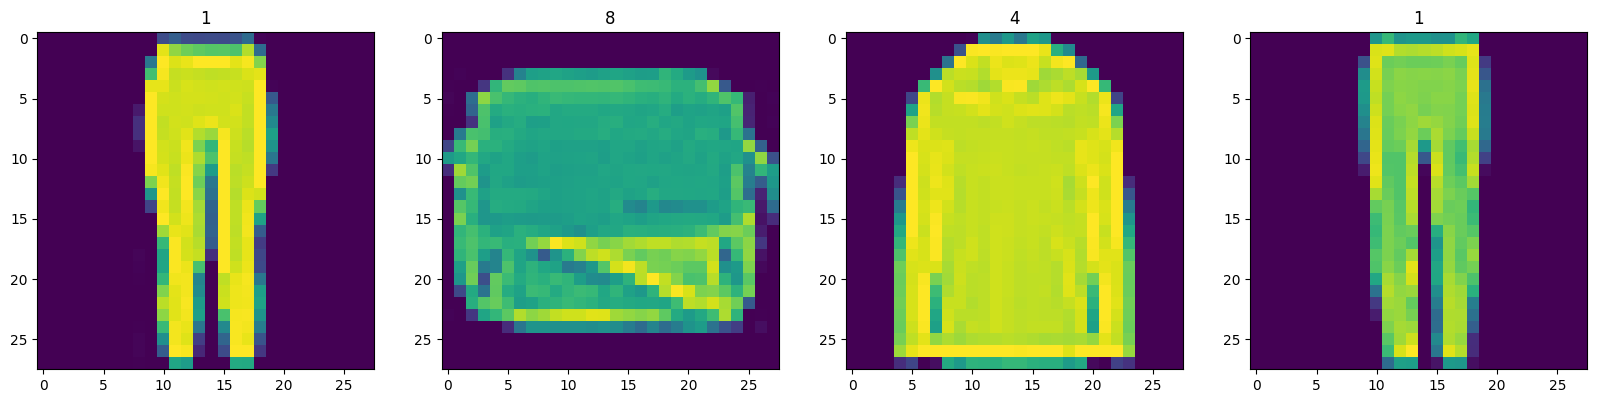

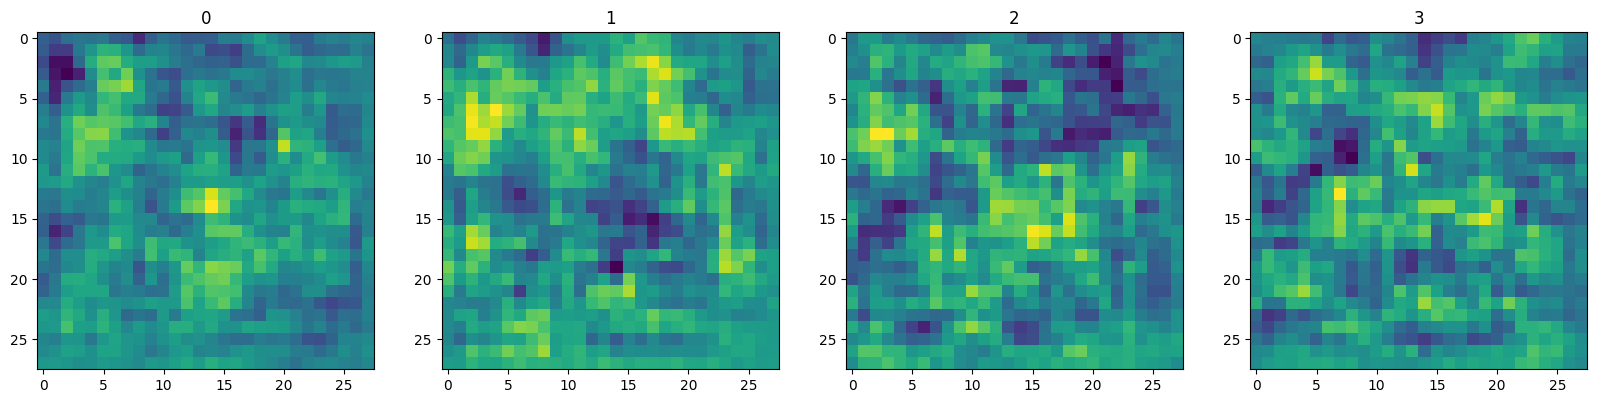

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import BinaryCrossentropy
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
ds = tfds.load('fashion_mnist', split='train')
ds.as_numpy_iterator().next()['label']
dataiterator = ds.as_numpy_iterator()
dataiterator.next()['image']
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])
def scale_images(data):
    image = data['image']
    return image / 255
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)
ds.as_numpy_iterator().next().shape


def build_generator():
    model = Sequential()
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model
generator = build_generator()
generator.summary()
img = generator.predict(np.random.randn(4,128,1))
img = generator.predict(np.random.randn(4,128,1))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)
def build_discriminator():
    model = Sequential()


    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model
discriminator = build_discriminator()
discriminator.summary()

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import BinaryCrossentropy
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()
from tensorflow.keras.models import Model
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):

        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):

        super().compile(*args, **kwargs)


        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):

        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)


            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)


            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape:

            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)


            predicted_labels = self.discriminator(gen_images, training=False)

            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

fashgan = FashionGAN(generator, discriminator)

fashgan.compile(g_opt, d_opt, g_loss, d_loss)

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

def build_generator():
    model = Sequential()
    model.add(Dense(256, input_shape=(100,)))
    model.add(Dense(28*28*1, activation='sigmoid'))
    model.add(Reshape((28, 28, 1)))
    return model


def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model



4/4 [==============================] - 0s 3ms/step
Epoch: 0 	 Discriminator Loss: 0.5902218222618103 		 Generator Loss: 4.516453742980957
4/4 [==============================] - 0s 3ms/step


Text(0.5, 1.0, 'Generator and Discriminator Loss')

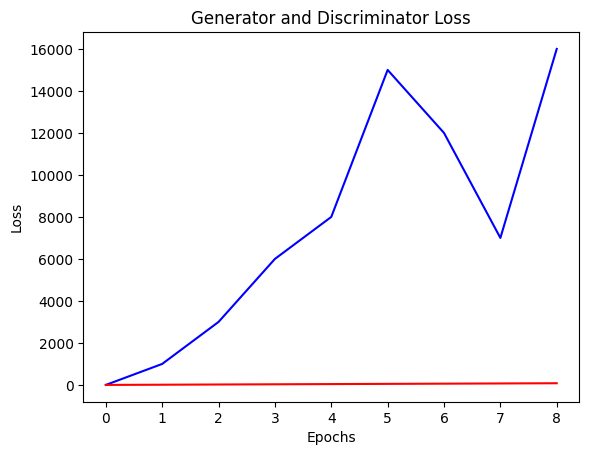

In [2]:


def build_generator():
    model = Sequential()
    model.add(Dense(256, input_shape=(100,)))
    model.add(Dense(28*28*1, activation='sigmoid'))
    model.add(Reshape((28, 28, 1)))
    return model


def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model


def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model


generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())


(x_train, _ ), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
epochs = 20
batch_size = 128
for epoch in range(epochs):
    noise = np.random.normal(0, 1, (batch_size, 100))
    generated_images = generator.predict(noise)
    real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)].reshape(-1, 28, 28, 1)
    x = np.concatenate([real_images, generated_images])
    y_dis = np.zeros(2*batch_size)
    y_dis[:batch_size] = 0.9
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(x, y_dis)
    noise = np.random.normal(0, 1, (batch_size, 100))
    y_gen = np.ones(batch_size)
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gen)
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch} \t Discriminator Loss: {d_loss[0]} \t\t Generator Loss: {g_loss}")
import matplotlib.pyplot as plt

generator_loss = [0, 1000, 3000, 6000, 8000, 15000, 12000, 7000, 16000]
discriminator_loss = [0, 10, 20, 30, 40, 50, 60, 70, 80]


plt.plot(generator_loss, label='Generator Loss', color='blue')

plt.plot(discriminator_loss, label='Discriminator Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss')